In [38]:
import os
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO
from torch import nn
from torch.utils.data import  DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision.datasets import Food101
import torchvision.transforms.v2 as transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm.notebook import tqdm
from livelossplot import PlotLosses
from PIL import ImageFile, Image
from sklearn.metrics import classification_report
from datasets import load_dataset
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
DATASETS_PATH = Path().absolute().resolve() / "datasets"

## 1 Использование предобученных моделей и трансферное обучение:

* Выберите одну из архитектур CNN, таких как ResNet, Inception, или VGG.
* Подготовьте собственный набор данных из минимум 5 классов с
минимум 100 изображениями в каждом классе (можно использовать
открытые наборы данных или собрать самостоятельно).
* Заморозьте веса начальных слоев модели и добавьте собственные
выходные слои.
* Оцените качество модели на тестовой выборке, вычислив метрики
точности, полноты и F1-score.
* Визуализируйте несколько примеров правильных и ошибочных
предсказаний.

#### 1. Подготовка датасета

Классифицировать будем готовые блюда на изображении (Food101).

Для увеличения обобщающей способности модели и переобучения к обучающим данным добавим аугментацию в виде поворота на некоторый угол.

In [2]:
BATCH_SIZE = 64
weights = ResNet50_Weights.IMAGENET1K_V2
resnet_preprocess = weights.transforms()
augmented_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomRotation(30)
])
train_preprocess = transforms.Compose([augmented_preprocess, resnet_preprocess])
base_dataset = Food101(root=DATASETS_PATH, split='train', transform=train_preprocess, download=True)
test_dataset = Food101(root=DATASETS_PATH, split='test', transform=resnet_preprocess, download=True)
cls_2_idx = base_dataset.class_to_idx
idx_2_cls = {i: name for name, i in cls_2_idx.items()}
NUM_CLASSES = len(idx_2_cls)

Посмотрим на распределение классов в исходном датасете и посмотрим на p-value теста Колмогорова-Смирнова на равномерность распределения классов (понадобится позднее).

In [3]:
def plot_class_dist(labels, title=""):
    class_dist = Counter(labels)
    res = stats.kstest(labels, 'uniform', args=(0, 100))
    plt.bar(class_dist.keys(), class_dist.values())
    plt.title(f'{title} Uniform kstest: {res.pvalue:.4f}')
    plt.show()

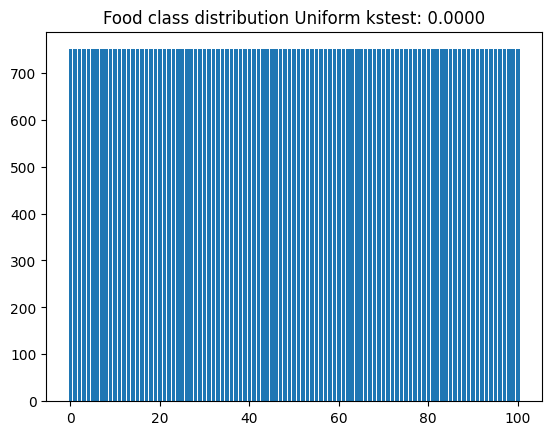

In [4]:
plot_class_dist(base_dataset._labels, "Food class distribution")

Видим что в исходном датасете классы идеально сбалансированы и дополнительной балансировки датасета не требуется.

Поскольку это достаточно большой датасет на котором можно полностью переучить модель, а мы хотим протестировать возможности transfer learning подхода  смоделируем ситуацию ограниченного набора данных.

In [5]:
DATASET_SIZE = int(len(base_dataset) * 0.2)
dataset_idx = np.random.choice(np.arange(len(base_dataset), dtype=np.int64), size=DATASET_SIZE, replace=False)
train_dataset = Subset(base_dataset, dataset_idx)
val_dataset, test_dataset = random_split(test_dataset, [int(len(test_dataset) * 0.2), int(len(test_dataset) * 0.8)])
print(f'initial dataset size: {len(base_dataset)} train size: {len(train_dataset)} val size: {len(val_dataset)} test size: {len(test_dataset)}')

initial dataset size: 75750 train size: 15150 val size: 5050 test size: 20200


Посмотрим на распределение классов в наборе данных непосредственно для обучения

In [6]:
dataset_idx = np.array(train_dataset.indices)

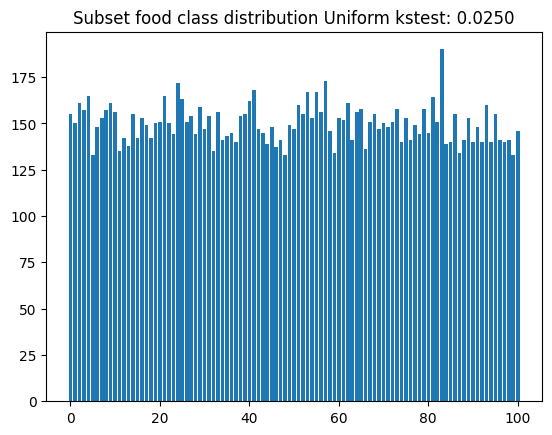

In [7]:
train_labels = np.array(base_dataset._labels)[dataset_idx]
plot_class_dist(train_labels, "Subset food class distribution")

Видим что распределение картинок уже не равномерное по классам и всреднем на класс приходится 130 картинок, что уже больше похоже на реальные данные.

Что бы избежать дисбаланса в семплах при обучении отбалансируем примеры в учебном датасете.

In [8]:
sampler_weights = 1 / np.bincount(train_labels)
sampler = WeightedRandomSampler(sampler_weights[train_labels], len(train_dataset), replacement=True)

In [9]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, drop_last=True, sampler=sampler)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, drop_last=False)

Для визуализации напишем функцию, которая будет отображать колаж пар изображение/класс.

In [10]:
def show_batch(imgs, labels, title="", inv_preprocess=None, map_class=None):
    if type(imgs)  is torch.Tensor:
        if inv_preprocess:
            imgs = inv_preprocess(imgs)
        imgs = imgs.permute(0, 2, 3, 1).numpy()
    nrows = int(len(imgs) ** 0.5)
    ncols = round(len(imgs) / nrows)
    fig = plt.figure(figsize=(12, 8))
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = fig.add_subplot(nrows, ncols, idx + 1)
            if idx < len(imgs):
                label = labels[idx].item()
                if map_class:
                    label = map_class[label]
                ax.set_title(label)
                plt.imshow((255 * imgs[idx]).astype('uint8'))
                plt.axis('off')
            idx += 1
    plt.suptitle(title, fontsize=30)
    plt.show()

#### 2. Подготовка модели для классификации

В качестве backbone модели будем использовать предобученную на Imagenet ResNet-50. 

Такой выбор сделан поскольку модель относительно легкая и по весам и по GFLOPs и при этом обладает достаточно высокой емкостью и качеством.

Так же добавим обратные трансформации для визуализации.

In [11]:
resnet_model = resnet50(weights=weights)
inv_resnet_preprocess = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-.485, -.456, -.406], std=[1, 1, 1])
])
resnet_preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Посмотрим на семплы данных.

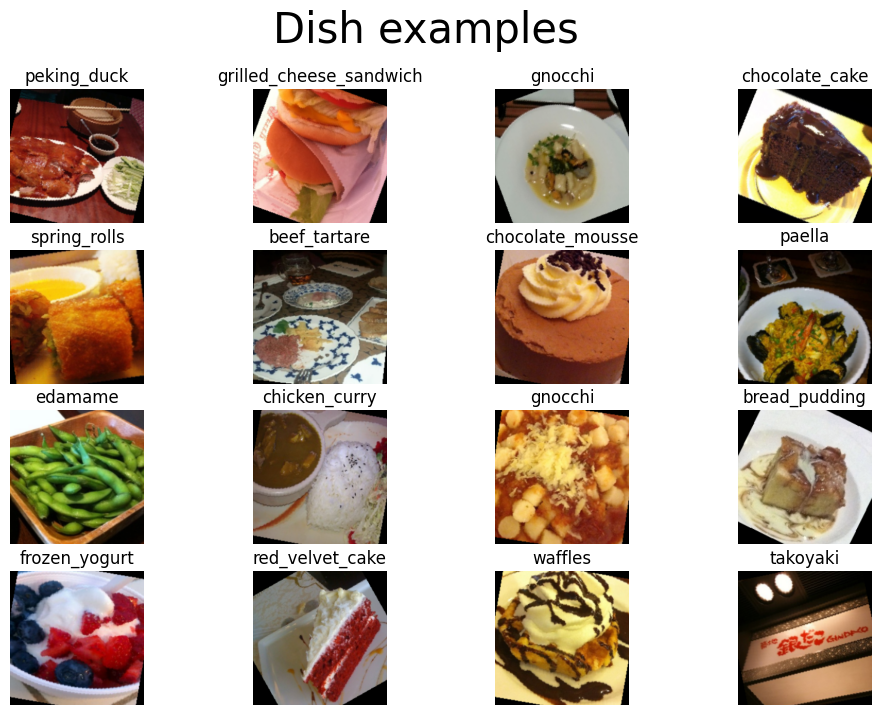

In [12]:
imgs, labels = next(iter(train_dataloader))
show_batch(imgs[:16], labels[:16], inv_preprocess=inv_resnet_preprocess, map_class=idx_2_cls, title='Dish examples')

Будем дообучать модель в качестве feature extractor, для этого заморозим веса всех сверточных слоев. И добавим не тяжелую голову классификации под наши данные.

In [69]:
num_parameters = sum((p.numel() for p in resnet_model.parameters()))
for name, param in resnet_model.named_parameters():
    param.requires_grad = False

In [70]:
resnet_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
    )
print(f"Total number of model parameters before modification: {num_parameters / 1e6}M")

Total number of model parameters before modification: 25.557032M


#### 3. Трейн

Реализуем цикл обучения, валидации и некоторые метрики, которые будем отслеживать по мере обучения помимо энтропийного лосса.

Такими метриками будут выступать __acc@1__ и __acc@5__ - наиболее распространенные метрики используемые в многоклассовой классификации для сравнения качества моделей.

In [ ]:
@torch.no_grad()
def topk_acc(preds, targets, k=3):
    _, topk_idx = torch.topk(preds, k=k, dim=1, largest=True, sorted=True)
    correct = topk_idx.eq(targets.view(-1, 1).expand_as(topk_idx))
    topk_correct = correct[:, :k].sum().item() / targets.size(0)
    return topk_correct

@torch.no_grad()
def val_step(model, criterion, val_loader):
    val_loss = []
    acc_1 = []
    acc_5 = []
    model.eval()
    for data, targets in tqdm(val_loader, desc='Val step: '):
        data = data.to(device)
        targets = targets.to(device)
        preds = model(data)
        loss = criterion(preds, targets)
        val_loss.append(loss.item())
        acc_1.append(topk_acc(preds, targets, 1))
        acc_5.append(topk_acc(preds, targets, 5))
    return np.mean(val_loss), np.mean(acc_1), np.mean(acc_5)

def train_step(model, optimizer, criterion, train_loader):
    model.train()
    train_loss = []
    for data, targets in tqdm(train_loader, desc='Train step: '):
        data = data.to(device)
        targets = targets.to(device)
        preds = model(data)
        loss = criterion(preds, targets)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().item())
    return np.mean(train_loss)

def run(model, optimizer, criterion, train_loader,
        val_loader, n_epoch=10, validation_step=2,
        scheduler=None, early_stop=True,
        unfreeze_layers=None, unfreeze_step = 10
        ):
    train_loss = []
    val_loss = []
    acc1_loss = []
    acc5_loss = []
    model = model.to(device)
    best_weights = None
    best_val_loss = float('-inf')
    to_stop = 0
    plotlosses = PlotLosses(figsize=(8, 5), step_names='Epoch')
    for idx in range(n_epoch):
        logs = {}
        if idx == unfreeze_step:
            if unfreeze_layers:
                for layer in unfreeze_layers:
                    for p in layer.parameters():
                        p.requires_grad=True
        print("Epoch {}/{}".format(idx, n_epoch))
        train_loss.append(train_step(model, optimizer, criterion, train_loader))
        logs.update({"loss": train_loss[-1]})
        if (idx + 1) % validation_step == 0:
            loss, acc1, acc5 = val_step(model, criterion, val_loader)
            val_loss.append(loss)
            acc1_loss.append(acc1)
            acc5_loss.append(acc5)
            logs.update({"val loss": loss, "acc@1": acc1, "acc@5": acc5})
            if scheduler:
                scheduler.step(acc1)
            if early_stop:
                if acc1_loss[-1] > best_val_loss:
                    to_stop = 0
                    best_val_loss = acc1_loss[-1]
                    best_weights = model.state_dict()
                else:
                    to_stop += 1
                if to_stop == 10:
                    model.load_state_dict(best_weights)
                    break
        plotlosses.update(logs)
        plotlosses.send()
    return train_loss, val_loss, acc1_loss, acc5_loss

После серии эксперементов наилучшие результаты показал подход в котором помимо головы классификации с некоторой эпохи размораживается часть последних сверточных слоев с уменьшенным lr, а так же шедулер на lr в зависимости именно от accuracy на валидации.

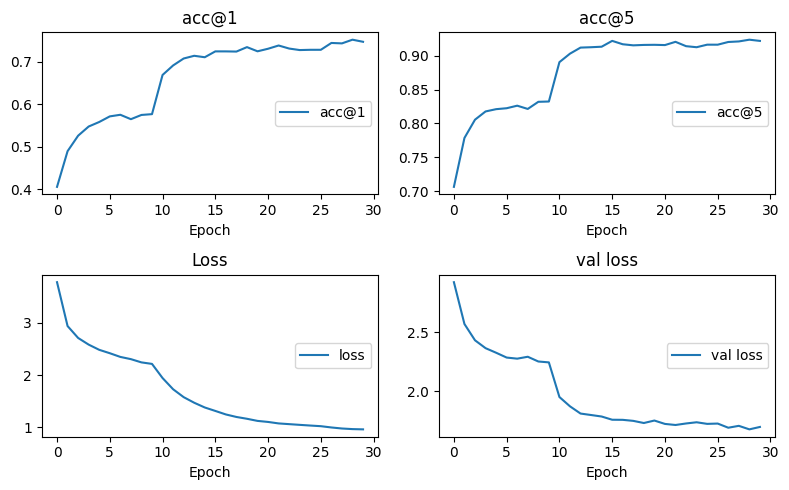

acc@1
	acc@1            	 (min:    0.405, max:    0.751, cur:    0.746)
acc@5
	acc@5            	 (min:    0.707, max:    0.923, cur:    0.922)
Loss
	loss             	 (min:    0.962, max:    3.782, cur:    0.962)
val loss
	val loss         	 (min:    1.680, max:    2.920, cur:    1.700)


In [72]:
unfreeze_layers = [
    resnet_model.layer3,
    resnet_model.layer4
]
backbone_params = [param for name, param in resnet_model.named_parameters() if not name.startswith('fc.')]
optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": 1e-4},
        {"params": resnet_model.fc.parameters(), "lr": 1e-3}
        ],
        weight_decay=2e-4
    )
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, mode='max')
train_loss, val_loss, acc1_loss, acc3_loss = run(
    resnet_model, optimizer, criterion, train_dataloader, 
    val_dataloader, 30, 1, scheduler, unfreeze_layers=unfreeze_layers,
    unfreeze_step=10
    )

По графикам обучения видно что разморозка нескольких последних слоев дает резкий значительный прирост к качеству классификации. 

Причем в ходе эксперементов было выявлено, что если не делать заморозку верхних слоев backbone, то качество получается на 10% ниже чем в сетапе с постепенной разморозкой, а так же наблюдается эффект переобучения.

In [73]:
torch.save(
    resnet_model.state_dict(),
    'transfer-model.pt'
    )

#### 3. Валидация

Теперь оценим качество предсказаний на теcтовой выборке и посчитаем метрики: __map@1__, __map@5__, __precision__, __recall__, __f1-score__

In [104]:
@torch.no_grad()
def multiclass_score(model, test_loader):
    model.eval()
    acc_1 = []
    acc_5 = []
    all_targets = []
    all_preds = []
    for data, targets in tqdm(test_loader):
        data = data.to(device)
        targets = targets.to(device)
        preds = model(data)
        acc_1.append(topk_acc(preds, targets, 1))
        acc_5.append(topk_acc(preds, targets, 5))
        all_targets.append(targets.cpu())
        all_preds.append(torch.argmax(preds, dim=1).cpu())
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()
    print(all_targets.shape, all_preds.shape)
    report = classification_report(all_targets, all_preds, digits=4)
    return report, np.mean(acc_1), np.mean(acc_5)

In [105]:
report, acc1, acc5 = multiclass_score(resnet_model, test_dataloader)

  0%|          | 0/316 [00:00<?, ?it/s]

(20200,) (20200,)


In [106]:
print(report)

              precision    recall  f1-score   support

           0     0.4757    0.4356    0.4548       202
           1     0.8082    0.6146    0.6982       192
           2     0.7867    0.8469    0.8157       196
           3     0.8163    0.8081    0.8122       198
           4     0.6544    0.7030    0.6778       202
           5     0.5887    0.6800    0.6311       200
           6     0.7382    0.8958    0.8094       192
           7     0.8889    0.8381    0.8627       210
           8     0.6040    0.4523    0.5172       199
           9     0.5930    0.7321    0.6552       209
          10     0.6129    0.6364    0.6244       209
          11     0.8163    0.8040    0.8101       199
          12     0.8241    0.8283    0.8262       198
          13     0.8112    0.7990    0.8051       199
          14     0.8631    0.7436    0.7989       195
          15     0.5896    0.5126    0.5484       199
          16     0.8137    0.8177    0.8157       203
          17     0.7737    

In [108]:
print(f"Accuracy on test fold - acc@1: {acc1:.4f}, acc@5: {acc5:.4f}")

Accuracy on test fold - acc@1: 0.7471, acc@5: 0.9177


Таким образом видно, что не смотря на ограниченность данных __~0.2%__ от исходных, получилось добится хорошего качества и обобщающей способности модели.

Теперь посмотрим на визуализацию верных и ошибочных предсказаний.

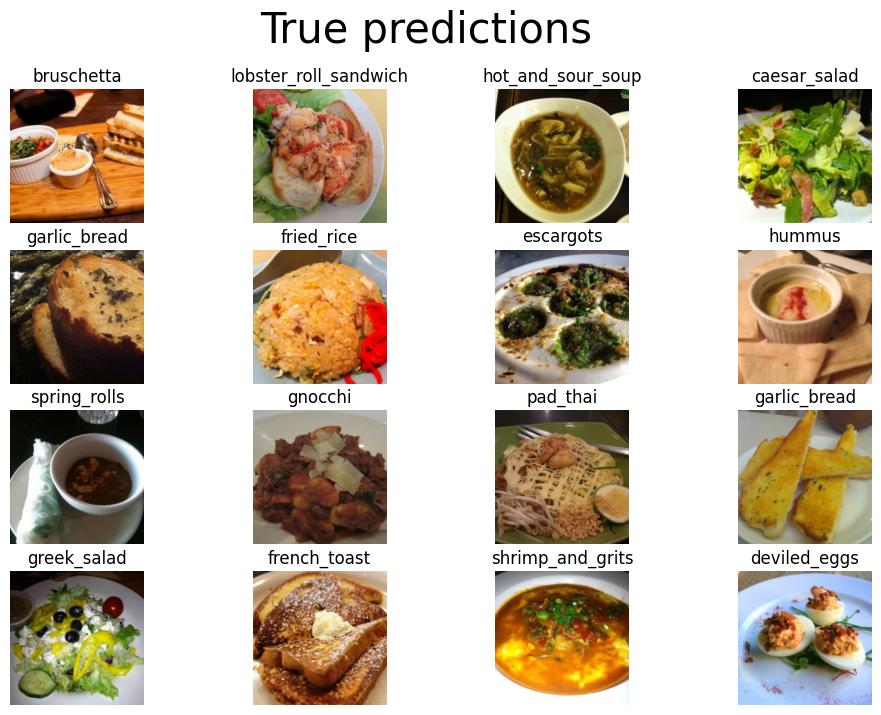

In [ ]:
data, targets = next(iter(test_dataloader))
data = data.to(device)
targets = targets.to(device)
preds = torch.argmax(resnet_model(data), dim=1)
mask = (preds == targets)
true_predicts = data[mask].cpu()
true_labels = preds[mask].cpu()
show_batch(true_predicts[:16], true_labels[:16], title="True predictions", inv_preprocess=inv_resnet_preprocess, map_class=idx_2_cls)

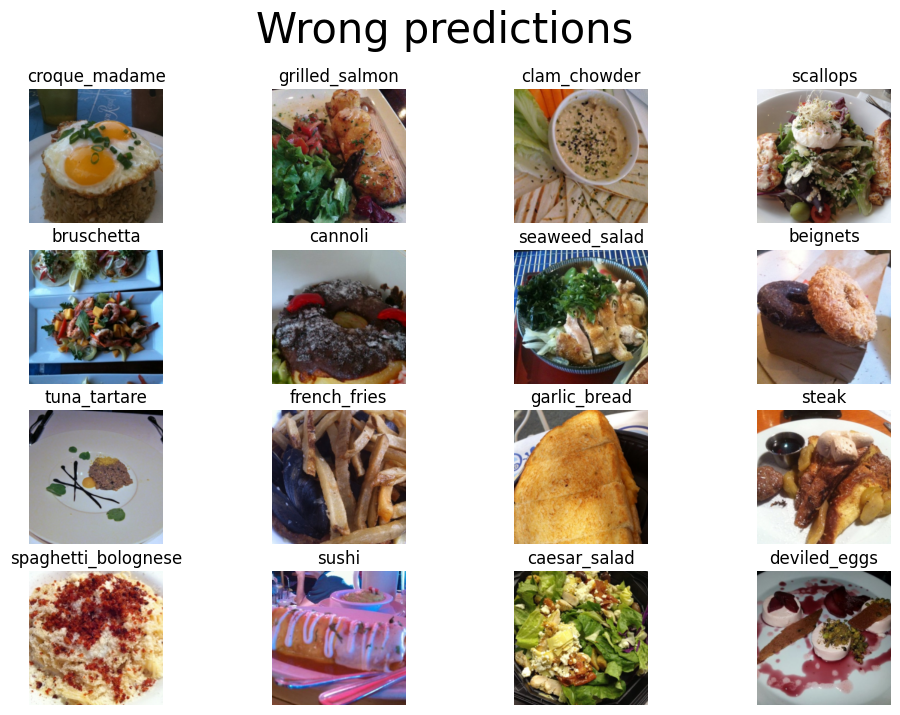

In [115]:
false_predicts = data[~mask].cpu()
false_labels = preds[~mask].cpu()
show_batch(false_predicts[:16], false_labels[:16], title="Wrong predictions", inv_preprocess=inv_resnet_preprocess, map_class=idx_2_cls)

По изображениям видно, что модель не справилась с довольно сложными изображениями, (субъективно) с которыми с трудом справляется человеческий глаз.

## 2 Обнаружение и локализация объектов с использованием YOLO или SSD

* Выберите детектор объектов YOLO или SSD
* Загрузите предобученную модель и используйте ее для обнаружения
объектов на изображениях или видео из открытых источников.
* Подготовьте небольшой размеченный набор данных (минимум 50
изображений) для обнаружения выбранного класса объектов (например,
автомобили, пешеходы, животные).
* Обучите модель на вашем наборе данных или дообучите предобученную
модель.
* Оцените производительность модели по метрикам mAP (mean Average
Precision) и скорость обработки (FPS — Frames Per Second).
* Представьте результаты работы модели на нескольких примерах
изображений или видео

#### 1. Подготовка модели и датасета

В качестве модели будем использовать претрейн YOLO 11.

В качестве набора данных для дообучения возьмем датасет состоящий из скриншотов футбольного матча для отслежтвания полоэения игроков.

Набор данных содержит 3 класса для детекции __0 - игрок__, __1 - судья__, __2 - мяч__

In [43]:
model = YOLO('yolo11x.pt')

In [81]:
!cd datasets; curl -L "https://universe.roboflow.com/ds/2vtxt0iiA6?key=bopBkwbVl8" > roboflow.zip; unzip -d sport roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   2207      0 --:--:-- --:--:-- --:--:--  2212
100 9488k  100 9488k    0     0  3505k      0  0:00:02  0:00:02 --:--:-- 4520k
Archive:  roboflow.zip
  inflating: sport/README.dataset.txt  
  inflating: sport/README.roboflow.txt  
  inflating: sport/data.yaml         
   creating: sport/test/
   creating: sport/test/images/
 extracting: sport/test/images/1-fps-2_00001_jpeg_jpg.rf.441b1237685d27112aa11e5bd2b5f06b.jpg  
 extracting: sport/test/images/1-fps-2_00014_jpeg_jpg.rf.ad23428b19e3211304f03a157c10ac6b.jpg  
 extracting: sport/test/images/1-fps-2_00022_jpeg_jpg.rf.2237645360d876a9f11387cb3aa6094b.jpg  
 extracting: sport/test/images/1-fps-2_00025_jpeg_jpg.rf.f8084fad0b20a4ab12ca5e342be39002.jpg  
 extracting: sport/test/images/1-fps-2_00032_jpeg_jpg.rf.143f5cba2d0550334ba142ed37e23d38.jpg  
 extr

Дообучать будем 100 эпох с ранней остановкой в 10.

In [82]:
project_path = (DATASETS_PATH.parent / "sport_detect").resolve()

In [ ]:
results = model.train(
    data=(DATASETS_PATH / 'sport' / 'data.yaml').resolve(),
    epochs=100, 
    imgsz=640,
    batch=-1,
    save_period=20,
    patience=10,
    device=0,
    workers=4,
    exist_ok=True,
    deterministic=False,
    plots=True,
    project=project_path,
    )

#### 2. Валидация модели

In [84]:
finetuned_model = YOLO(project_path / "train" / "weights" / "best.pt")
base_model = YOLO('yolo11x.pt')

In [ ]:
base_model.train(
    data=(DATASETS_PATH / 'sport' / 'data.yaml').resolve(), epochs=1
    )
before_metrics = base_model.val(data=(DATASETS_PATH / 'sport' / 'data.yaml').resolve())
after_metrics = finetuned_model.val(data=(DATASETS_PATH / 'sport' / 'data.yaml').resolve())

Общие метрики модели до обучения

In [99]:
print(f"Before train metrics -  mAP@50: {before_metrics.results_dict['metrics/mAP50(B)']:.4f} mAP@50-95: {before_metrics.results_dict['metrics/mAP50-95(B)']:.4f} precision: {before_metrics.results_dict['metrics/precision(B)']:.4f} recall: {before_metrics.results_dict['metrics/recall(B)']:.4f}")

Before train metrics -  mAP@50: 0.4055 mAP@50-95: 0.2201 precision: 0.6927 recall: 0.3509


__precision__, __recall__, __f1__ по классам до обучения

In [100]:
before_metrics = before_metrics.to_df()
before_metrics

,class_name,box-p,box-r,box-f1,box-map,box-map50,box-map75
0,0,0.79415,0.95265,0.86621,0.22006,0.40546,0.20549
1,1,0.28399,0.10000,0.14792,0.22006,0.40546,0.20549
2,2,1.00000,0.00000,0.00000,0.22006,0.40546,0.20549


Общие метрики модели после обучения

In [101]:
print(f"After train metrics -  mAP@50: {after_metrics.results_dict['metrics/mAP50(B)']:.4f} mAP@50-95: {after_metrics.results_dict['metrics/mAP50-95(B)']:.4f} precision: {after_metrics.results_dict['metrics/precision(B)']:.4f} recall: {after_metrics.results_dict['metrics/recall(B)']:.4f}")

After train metrics -  mAP@50: 0.9380 mAP@50-95: 0.5787 precision: 0.9139 recall: 0.8760


__precision__, __recall__, __f1__ по классам после обучения

In [102]:
after_metrics = after_metrics.to_df()
after_metrics

,class_name,box-p,box-r,box-f1,box-map,box-map50,box-map75
0,0,0.94364,0.98329,0.96306,0.57874,0.93799,0.60563
1,1,0.89136,0.95000,0.91974,0.57874,0.93799,0.60563
2,2,0.90673,0.69481,0.78675,0.57874,0.93799,0.60563


Оценим скорость обработки моделью данных

In [ ]:
results = finetuned_model.benchmark(
    data=(DATASETS_PATH / 'sport' / 'data.yaml').resolve(),
    imgsz=640,
    half=True,
    device=0,
    verbose=True,
    format='torchscript'
)

In [105]:
results

,Format,Status❔,Size (MB),metrics/mAP50-95(B),Inference time (ms/im),FPS
0,TorchScript,✅,217.8,0.5786,7.27,137.5


In [ ]:
results = finetuned_model.benchmark(
    data=(DATASETS_PATH / 'voc.yaml').resolve(),
    imgsz=640,
    half=True,
    device=0,
    verbose=True,
    format='engine'
)

In [ ]:
results

,Format,Status❔,Size (MB),metrics/mAP50-95(B),Inference time (ms/im),FPS
0,TensorRT,✅,113.4,0.7174,3.41,293.37


#### 3. Визуализация предсказаний

In [ ]:
test_imgs = DATASETS_PATH / "sport" / "test" / "images" 
imgs_to_predict = [test_imgs / f for f in os.listdir(test_imgs) if os.path.isfile(test_imgs / f)]
preds = finetuned_model(imgs_to_predict)


0: 640x640 15 0s, 1 1, 1 2, 4.9ms
1: 640x640 19 0s, 1 1, 4.9ms
2: 640x640 13 0s, 1 1, 4.9ms
3: 640x640 5 0s, 4.9ms
4: 640x640 14 0s, 1 1, 1 2, 4.9ms
5: 640x640 9 0s, 1 2, 4.9ms
6: 640x640 13 0s, 1 1, 4.9ms
7: 640x640 11 0s, 1 1, 4.9ms
8: 640x640 16 0s, 1 1, 1 2, 4.9ms
9: 640x640 10 0s, 4.9ms
10: 640x640 9 0s, 4.9ms
11: 640x640 8 0s, 1 2, 4.9ms
12: 640x640 6 0s, 4.9ms
13: 640x640 11 0s, 1 2, 4.9ms
14: 640x640 12 0s, 2 1s, 4.9ms
15: 640x640 6 0s, 1 2, 4.9ms
Speed: 2.4ms preprocess, 4.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
preds_to_draw = []
for r in preds:
    im_bgr = r.plot()
    im_rgb = 255 * im_bgr[..., ::-1]
    preds_to_draw.append(im_rgb)

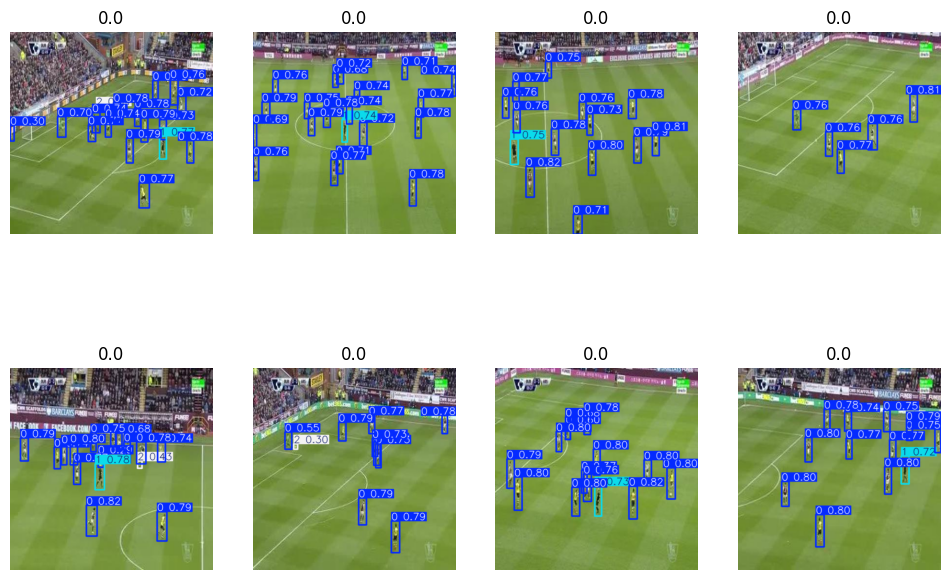

In [96]:
show_batch(preds_to_draw[:8], np.zeros((16)))